<a href="https://colab.research.google.com/github/aliakbarbadri/persian-poetry-creator/blob/master/char-RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Load the data

In [0]:
# ! wget --no-check-certificate https://github.com/aliakbarbadri/persian-poetry-creator/blob/master/Shahnameh.zip?raw=true -O /tmp/Shahnameh.zip
# ! unzip /tmp/Shahnameh.zip 

In [0]:
# import os
# corpus_url = "Shahnameh/shahname"
# corpus = ""
# for filename in os.listdir(corpus_url):
#    with open(os.path.join(corpus_url, filename), 'r') as f:
#       text = f.read()
#       corpus += text
#       corpus += "\n"

In [0]:
# file_corpus = open("shahname.txt", "a")
# file_corpus.write(corpus)
# file_corpus.close()

In [0]:
url = "https://raw.githubusercontent.com/aliakbarbadri/persian-poetry-creator/master/shahname.txt"
filepath = keras.utils.get_file("shahname.txt", url) 
with open(filepath) as f:
  corpus = f.read()

In [6]:
len(corpus)

2555369

In [0]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True) 
tokenizer.fit_on_texts([corpus])

In [8]:
tokenizer.texts_to_sequences(["سلام"])

[[14, 25, 2, 10]]

In [9]:
tokenizer.sequences_to_texts([[14, 25, 2, 10]])

['س ل ا م']

In [10]:
"".join(sorted(set(corpus)))

'\t\n ()«»،؟ءآأؤئابتثجحخدذرزسشصضطظعغفقلمنهؤپچژکگی\u200c'

In [11]:
max_id = len(tokenizer.word_index)
dataset_size = len(corpus)
max_id,dataset_size

(48, 2555369)

In [0]:
[encoded] = np.array(tokenizer.texts_to_sequences([corpus])) - 1

In [0]:
train_size = dataset_size * 60 // 100

In [0]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead 
batch_size = 32

# Stateless RNN

In [0]:
# dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
# dataset = dataset.window(window_length, shift=1, drop_remainder=True)
# dataset = dataset.flat_map(lambda window: window.batch(window_length))
# dataset = dataset.shuffle(10000).batch(batch_size)
# dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
# dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
# dataset = dataset.prefetch(1)
# for X_batch, Y_batch in dataset.take(1):
#     print(X_batch.shape, Y_batch.shape)

In [0]:
# model = keras.models.Sequential([
#     tf.compat.v1.keras.layers.CuDNNGRU(128, return_sequences=True, 
#                                        input_shape=[None, max_id],
#                                        recurrent_regularizer=keras.regularizers.l2(1e-4)),
#     tf.compat.v1.keras.layers.CuDNNGRU(128, return_sequences=True,
#                                        recurrent_regularizer=keras.regularizers.l2(1e-4)),
#     keras.layers.TimeDistributed(keras.layers.Dense(max_id,
#                                                     activation="softmax"))
# ])
# model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [0]:
# history = model.fit(dataset, steps_per_epoch=train_size // batch_size,epochs=10)

# Stateful RNN

In [0]:
tf.random.set_seed(42)

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True) 
dataset = dataset.flat_map(lambda window: window.batch(window_length)) 
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:])) 
dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch)) 
dataset = dataset.prefetch(1)

In [0]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [0]:
model = keras.models.Sequential([
  keras.layers.GRU(128, return_sequences=True, stateful=True,recurrent_regularizer=keras.regularizers.l2(1e-2),
                    batch_input_shape=[batch_size, None, max_id]), 
  keras.layers.GRU(128, return_sequences=True, stateful=True,recurrent_regularizer=keras.regularizers.l2(1e-2)),                   
  keras.layers.TimeDistributed(keras.layers.Dense(max_id,activation="softmax"))
])

In [0]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [0]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps

In [44]:
history = model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=50, callbacks=[ResetStatesCallback()])

Epoch 1/50
479/479 [==============================] - 24s 50ms/step - loss: 2.7273
Epoch 2/50
479/479 [==============================] - 24s 49ms/step - loss: 2.2234
Epoch 3/50
479/479 [==============================] - 24s 49ms/step - loss: 2.0902
Epoch 4/50
479/479 [==============================] - 24s 49ms/step - loss: 1.9869
Epoch 5/50
479/479 [==============================] - 24s 49ms/step - loss: 1.9335
Epoch 6/50
479/479 [==============================] - 24s 49ms/step - loss: 1.8959
Epoch 7/50
479/479 [==============================] - 23s 49ms/step - loss: 1.8660
Epoch 8/50
479/479 [==============================] - 24s 49ms/step - loss: 1.8401
Epoch 9/50
479/479 [==============================] - 23s 48ms/step - loss: 1.8176
Epoch 10/50
479/479 [==============================] - 23s 49ms/step - loss: 1.7981
Epoch 11/50
479/479 [==============================] - 23s 48ms/step - loss: 1.7810
Epoch 12/50
479/479 [==============================] - 24s 49ms/step - loss: 1.7658
E

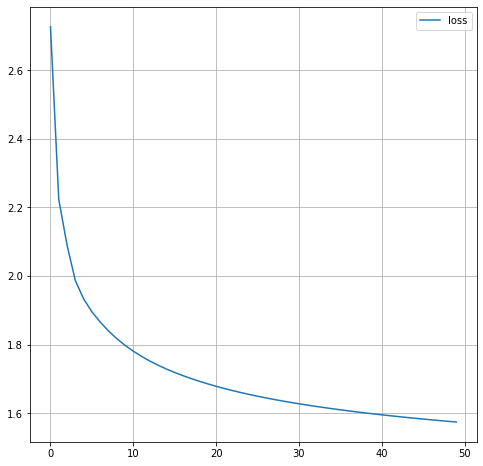

In [61]:
pd.DataFrame({'loss':history.history['loss'],
              # 'valid_loss':history.history['val_loss'],
              }).plot(figsize=(8, 8))
plt.grid(True)

In [0]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,activation="softmax"))
])

In [0]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [0]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [0]:
model.save("char_rnn_gru.h5")

# Use model

In [0]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [50]:
import warnings
warnings.filterwarnings('ignore')

X_new = preprocess(["که"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

' '

In [51]:
tf.random.set_seed(42)
tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        2, 0, 0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0]])

In [0]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [53]:
tf.random.set_seed(42)
next_char("که ایران چو با", temperature=1)

'ش'

In [0]:
def complete_text(text, n_chars=100, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [62]:
tf.random.set_seed(42)
print(complete_text("که ایران چو باغی ست خرم بهار", temperature=0.2))

که ایران چو باغی ست خرم بهار

چو بر تیر و بر تیره شد از درد و گاه
به پیش آمد از خواب و به داد	به نزدیک شاه با راه بود	به دیدار گ
